# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F # The activation funtions
from torchvision import datasets, transforms, models
from torch import nn

In [2]:
!ls flowers/ -la

total 20
drwxr-xr-x   5 root root 4096 Oct 12  2018 .
drwxr-xr-x   3 root root 4096 Oct 12  2018 ..
drwxrwxr-x 104 1000 1000 4096 Jan 15  2018 test
drwxrwxr-x 104 1000 1000 4096 Jan 15  2018 train
drwxrwxr-x 104 1000 1000 4096 Jan 15  2018 valid


In [3]:
# Determination between CPU and GUP
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [4]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [5]:
exp_mean = [0.485, 0.456, 0.406]
exp_std = [0.229, 0.224, 0.225]
max_img_size = 224
batch_size = 100

# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    "training": transforms.Compose([
        transforms.RandomRotation(25), # Rotate degree
        transforms.RandomResizedCrop(max_img_size), # Resising
        transforms.RandomHorizontalFlip(), # flip horizontally
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(), # Covert into Tensor
        transforms.Normalize(exp_mean, exp_std)
    ]),
    # validation and testing have the same transforms.
    "validation": transforms.Compose([
        transforms.Resize(max_img_size+1),
        transforms.CenterCrop(max_img_size),
        transforms.ToTensor(),
        transforms.Normalize(exp_mean, exp_std)
    ]),
    "testing": transforms.Compose([
        transforms.Resize(max_img_size+1),
        transforms.CenterCrop(max_img_size),
        transforms.ToTensor(),
        transforms.Normalize(exp_mean, exp_std)
    ])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    "training" : datasets.ImageFolder(train_dir, transform=data_transforms["training"]),
    "validation": datasets.ImageFolder(valid_dir, transform=data_transforms["validation"]),
    "testing": datasets.ImageFolder(test_dir, transform=data_transforms["testing"])
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    "training" : torch.utils.data.DataLoader(image_datasets["training"], batch_size=batch_size, shuffle=True),
    "validation": torch.utils.data.DataLoader(image_datasets["validation"],batch_size=batch_size),
    "testing": torch.utils.data.DataLoader(image_datasets["testing"], batch_size=batch_size)
}

print("----------- Dataset summaray -----------")
print("Batch size:", batch_size)
print('training images size: ', len(image_datasets['training']))
print('validation images size: ', len(image_datasets['validation']))
print('testing images size: ', len(image_datasets['testing']))

----------- Dataset summaray -----------
Batch size: 100
training images size:  6552
validation images size:  818
testing images size:  819


In [21]:
# A  function to covert Tensor into Image
def im_convert(tensor, exp_mean = [0.485, 0.456, 0.406], exp_std=[0.229, 0.224, 0.225]):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array(exp_mean) + np.array(exp_std)
  image = image.clip(0, 1)
  return image

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [17]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [68]:
print("{} labels categories were loaded.".format(len(cat_to_name)))

102 labels categories were loaded.


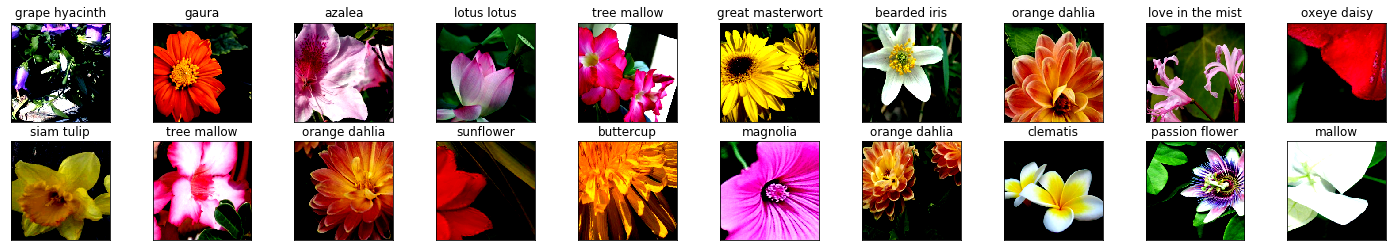

In [69]:
# Plots some images to see the transforms 
training_img_iter = iter(dataloaders["training"])
images, labels = training_img_iter.next()
fig = plt.figure(figsize=(25, 4))


for idx in np.arange(20):
    axe = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx], exp_mean=exp_mean, exp_std=exp_std))
    axe.set_title(cat_to_name[str(labels[idx].item())])

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [76]:
# TODO: Build and train your network
def buildModel(lr=0.001):
    
    # Load vgg pretrained from torchvision
    model = models.vgg16(pretrained=True)
    # The VGG16 has been proved very accuracy. It archieved more than 95% accracy. 
    # (https://neurohive.io/en/popular-networks/vgg16/)
    # From the previous output we can see VGG16 has 7 layers in its classifier pipeline.
    # The hidden layer (position 3) has 4096 units. we can reduce the number.
    # We can use replace its original layer with new layer by tunning some hyper-parameters.

    # Create our Lossfucntion(criterion) and optimizer.
    # Since this is a image classfication problem, we chosse the best loss function to be CrossEntropyLoss,
    # We use Adam as optimier set learning rate at 0.0001
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

    # Frezz model's parameters during the feature detection phrase.
    for param in model.parameters():
        param.requires_grad = False 

    # Input layer size
    n_input = model.classifier[0].in_features
    # Hidden layer size
    n_hidden = [500, 100]
    # Output layer size
    n_output = len(cat_to_name)

    from collections import OrderedDict

    my_classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(n_input, n_hidden[0])),
        ('relu1', nn.ReLU()),
        ('dropout1',nn.Dropout(p=0.5)),
        ('fc2', nn.Linear(n_hidden[0], n_hidden[1])),
        ('relu2', nn.ReLU()),
        ('dropout2',nn.Dropout(p=0.5)),
        ('fc3', nn.Linear(n_hidden[1],n_output)),
        ('output', nn.LogSoftmax(dim=1))
    ]))

    # Replace classifier
    model.classifier = my_classifier
    
    # Use NLLLoss as criterion
    criterion = nn.NLLLoss()
    # Optimizer
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr)
    
    return model, criterion, optimizer

In [79]:
# The training function
def train_model(model, criterion, optimizer, epochs, training_loader, validation_loader):
    
    model.train()
    # Use GPU if it is possible    
    if torch.cuda.is_available():
        model.cuda()
    else:
        model.cpu()
            
    for e in range(epochs):
        running_loss = 0
        
        for images, labels in training_loader:
            # Move images and labels to device
            images = images.to(device)
            labels = labels.to(device)
            
            # reset the gredients
            optimizer.zero_grad()
            
            # Forward and backward propagation
            log_ps = model.forward(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            
            # running loss
            running_loss += loss.item()
            
        else:
            model.eval()
            accuracy = 0
            vaild_loss  = 0
            with torch.no_grad():
                for images, labels in validation_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    log_ps = model(images)
                    vaild_loss += criterion(log_ps, labels)
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
        
            running_loss = running_loss / len(training_loader)
            valid_loss = vaild_loss / len(validation_loader)
            accuracy = accuracy / len(validation_loader)
            print("epoch {0}/10 Training loss: {1} ".format(e+1,running_loss),
                 "Vaildation loss: {}".format(valid_loss),
                 "Accurancy:{}".format(accuracy))

In [80]:
my_model, criterion, optimizer = buildModel()
train_model(my_model, criterion, optimizer, 5, dataloaders["training"], dataloaders["validation"])

epoch 1/10 Training loss: 4.263691757664536  Vaildation loss: 3.3110806941986084 Accurancy:0.26777777075767517
epoch 2/10 Training loss: 2.155488617492445  Vaildation loss: 1.1714637279510498 Accurancy:0.6755555272102356
epoch 3/10 Training loss: 1.1420958213733905  Vaildation loss: 0.6984193325042725 Accurancy:0.8130863904953003
epoch 4/10 Training loss: 0.8858228334874818  Vaildation loss: 0.5216120481491089 Accurancy:0.859259307384491
epoch 5/10 Training loss: 0.7487130837910103  Vaildation loss: 0.5197950601577759 Accurancy:0.859259307384491


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [97]:
# TODO: Do validation on the test set
size = 0
correct = 0
model.eval()
with torch.no_grad():
        for images, labels in dataloaders["testing"]:
            images,labels = images.to('cuda'), labels.to('cuda')
            log_ps = my_model(images)
            vaild_loss += criterion(log_ps, labels)
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            size += labels.size(0)
            correct += equals.sum().item()
test_accuracy = correct / size
print("Accurancy:{:.4f}".format(test_accuracy))

Accurancy:0.8107


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [101]:
# TODO: Save the checkpoint 
def save_model_state(model, optimizer, epoch,  training_dataset, file='model.pth'):
    model.class_to_idx = training_dataset.class_to_idx
    model_state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer_dict': optimizer.state_dict(),
        'classifier': model.classifier,
        'class_to_idx': model.class_to_idx
    }
    torch.save(model_state, file)
    

In [102]:
save_model_state(my_model, optimizer, 5, image_datasets["training"])

In [104]:
!ls -la

total 205924
drwxr-xr-x 5 root root      4096 Mar  3 18:40 .
drwxr-xr-x 4 root root      4096 Apr  1  2019 ..
drwxr-xr-x 2 root root      4096 Apr  1  2019 assets
-rw-r--r-- 1 root root      2218 Mar  5  2018 cat_to_name.json
lrwxrwxrwx 1 root root        21 Oct 13  2018 flowers -> ../../../data/flowers
drwxr-xr-x 8 root root      4096 Apr  1  2019 .git
-rw-r--r-- 1 root root      1157 Feb  6  2018 .gitignore
-rw-r--r-- 1 root root    452411 Mar  3 18:40 Image Classifier Project.ipynb
-rw-r--r-- 1 root root     15677 Aug  5  2018 Image Classifier Project-zh.ipynb
drwxr-xr-x 2 root root      4096 Apr  1  2019 .ipynb_checkpoints
-rw-r--r-- 1 root root      1064 Feb  6  2018 LICENSE
-rw-r--r-- 1 root root 210136861 Mar  3 18:40 model.pth
-rw-r--r-- 1 root root         0 Feb  6  2018 predict.py
-rw-r--r-- 1 root root       250 Apr 20  2018 README.md
-rw-r--r-- 1 root root         0 Feb  6  2018 train.py
-rw-r--r-- 1 root root      1540 Sep 28  2018 workspace-utils.py


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [6]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_model_by_state(file="model.pth"):
    model_state = torch.load(file, map_location= lambda storage, loc : storage)
    
    model = models.vgg16(pretrained=True)
    model.classifier = model_state['classifier']
    model.load_state_dict(model_state['state_dict'])
    model.class_to_idx = model_state['class_to_idx']
    
    return model

In [8]:
my_model = load_model_by_state()

In [9]:
# Check if model load successfully
my_model.classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=500, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5)
  (fc3): Linear(in_features=100, out_features=102, bias=True)
  (output): LogSoftmax()
)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [10]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    exp_mean = [0.485, 0.456, 0.406]
    exp_std = [0.229, 0.224, 0.225]
    max_img_size = 224
    
    transform = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(max_img_size),
        transforms.ToTensor(),
        transforms.Normalize(exp_mean, exp_std)
    ])
    
    
    from PIL import Image
    
    image = Image.open(image)
    image = transform(image)
    return image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [11]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [12]:
!ls ./flowers/test/102/image_08012.jpg

./flowers/test/102/image_08012.jpg


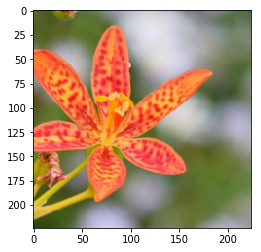

In [13]:
img_path = './flowers/test/102/image_08012.jpg'
image = process_image(img_path)
imshow(image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [14]:
# TODO: Implement the code to predict the class from an image file
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    model.to(device)
    # get image as tensor
    img = process_image(image_path)
    img = img.to(device)
    img = img.unsqueeze_(0)
    # covert tensor to flot tensor for computing
    img = img.float()
    with torch.no_grad():
        log_ps = model.forward(img)
    probability = torch.exp(log_ps)
    prob, label = probability.topk(topk)
    classes_index = []
    for i in np.array(label[0]):
        for idx, num in model.class_to_idx.items():
            if num == i:
                classes_index += [idx]
            
    
    return prob.view(-1).tolist(), classes_index

In [15]:
probs, classes = predict(img_path, my_model)
print(probs)
print(classes)

[0.9996405243873596, 0.00020669065997935832, 0.00010143409599550068, 2.2337433620123193e-05, 8.247898222180083e-06]
['102', '79', '84', '6', '18']


From this test we can see the `./flowers/test/102/image_08012.jpg` was classified well, the first one class is also 102.

In [ ]:
s = "./flowers/test/102/image_08012.jpg"
reg = 

In [18]:
cat_to_name['102']

'blackberry lily'

In [22]:
# TODO: Display an image along with the top 5 classes

def show_top5_classes(image_path, model):
    # get the prediction 
    image = process_image(image_path)
    probs, classes = predict(image_path, model)
    labels = [cat_to_name[str(i)] for i in classes]
    # Plots image and its probability in 2 columns
    fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
    ax1.imshow(im_convert(image))
    # Plots the labels
    ax2.set_yticks(np.arange(len(labels)))
    ax2.set_yticklabels(labels)
    ax2.set_xlabel("Probablity")
    ax2.invert_yaxis()
    ax2.barh(np.arange(len(labels)), probs, xerr=0, align='center', color='blue')
    fig.subplots_adjust(wspace=.6)

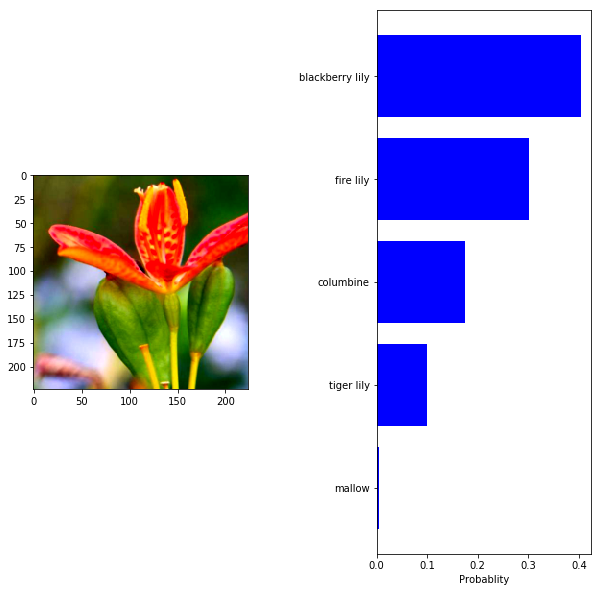

In [23]:
show_top5_classes('./flowers/test/102/image_08030.jpg',my_model)

This bar graph show the top-5 class candidates our model predicted base on the input image. Since our model score 85% accuracy in average, some time the top 1 class's probability was dominant others. We can conclude that our model can work well as we expected.